In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  3 14:36:26 2025

@author: julien.hautot
"""

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np

# --- Hyperparamètres ---
env_name = "Hopper-v5"
gamma = 0.99                   
lr = 3e-4                     
clip_eps = 0.2 # Coefficient de clip PPO 
epochs = 800                  
steps_per_epoch = 2048         
batch_size = 64                
entropy_coef = 0.01 # empeche le collapsing de la politique            

device = "cuda" if torch.cuda.is_available() else "cpu"


# --- Environnement ---
env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# --- Réseau Policy (Gaussian) ---
# Actor
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, act_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim))  

    # Création de la distribution gaussienne 
    def forward(self, x):
        mean = self.net(x)
        std = torch.exp(self.log_std)
        return mean, std


# --- Réseau Value ---
# Critic
class Value(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)  # retourne Vϕ(s) ie estime la valeur de l'et
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


# --- Initialisation ---
policy = Policy().to(device)
value = Value().to(device)
optimizer_policy = optim.Adam(policy.parameters(), lr=lr)
optimizer_value = optim.Adam(value.parameters(), lr=lr)

# --- Fonction pour générer trajectoires ---
def collect_trajectories():
    obs = env.reset()[0]
    obs_list, act_list, rew_list, logp_list, val_list, done_list = [], [], [], [], [], []
    for _ in range(steps_per_epoch):
        obs_tensor = torch.FloatTensor(obs).to(device)
        mu, std = policy.forward(obs_tensor)
        dist = torch.distributions.Normal(mu, std)
        act = dist.sample()                     
        logp = dist.log_prob(act).sum() 
        val = value.forward(obs_tensor)

        # Scale action to environment
        act_clamped = torch.tanh(act) # Environment est déjà entre -1,1 et tanh envoi les actions aussi sur -1,1
        next_obs, rew, terminated, truncated, _ = env.step(act_clamped.cpu().detach().numpy())
        done = terminated or truncated

        # Stockage
        obs_list.append(obs)
        act_list.append(act.detach())
        rew_list.append(rew)
        logp_list.append(logp.detach())
        val_list.append(val.detach())
        done_list.append(done)

        obs = next_obs
        if done:
            obs = env.reset()[0]

    return obs_list, act_list, rew_list, logp_list, val_list, done_list

# --- Fonction pour calculer les avantages (GAE) et les retours ---
def compute_advantages(rews, vals, dones):
    advs, gae = [], 0
    vals = vals + [0]  # V(s_T) = 0 
    # Parcours des rewards de l'épisode à l'envers
    for t in reversed(range(len(rews))):
        # Calcul du TD error : delta = r + gamma * V(s_{t+1}) - V(s_t)
        delta = rews[t] + gamma * vals[t + 1] * (1 - dones[t]) - vals[t]
        gae = delta + gamma * 0.95 * (1 - dones[t]) * gae # Avantage qui est généralisé
        advs.insert(0, gae) 
         
    returns = [advs[i] + vals[i] for i in range(len(advs))]
    advs = torch.tensor(advs, dtype=torch.float32).to(device)
    advs = (advs - advs.mean()) / (advs.std() + 1e-8) # normalisation des avantages 
    return advs, torch.FloatTensor(returns).to(device)

history_rewards = []
# --- Entraînement ---
for epoch in range(epochs):
    obs_list, act_list, rew_list, logp_list, val_list, done_list = collect_trajectories()
    advs, returns = compute_advantages(rew_list, val_list, done_list)    
    obs_tensor = torch.FloatTensor(obs_list).to(device)
    act_tensor = torch.stack(act_list).to(device)
    old_logp_tensor = torch.stack(logp_list).to(device)
    
    # --- Mise à jour PPO ---
    for _ in range(10):  # 10 mini-epochs
        idx = np.random.permutation(len(obs_list))
        for start in range(0, len(obs_list), batch_size):
            end = start + batch_size
            batch_idx = idx[start:end]

            obs_b = obs_tensor[batch_idx]
            act_b = act_tensor[batch_idx]
            adv_b = advs[batch_idx]
            ret_b = returns[batch_idx]
            old_logp_b = old_logp_tensor[batch_idx]

            # Policy
            mu, std = policy(obs_b)
            dist = torch.distributions.Normal(mu, std)
            logp = dist.log_prob(act_b).sum(axis=-1)
            entropy = dist.entropy().sum(axis=-1).mean()
            ratio = (logp - old_logp_b).exp()
            surr1 = ratio * adv_b
            surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_b
            loss_policy = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            # Value
            val_pred = value(obs_b)
            loss_value = torch.nn.functional.mse_loss(val_pred, ret_b)

            # Backprop
            optimizer_policy.zero_grad()
            loss_policy.backward()
            optimizer_policy.step()

            optimizer_value.zero_grad()
            loss_value.backward()
            optimizer_value.step()


    # --- Stats ---
    history_rewards.append(np.mean(rew_list))
    print(f"Epoch {epoch+1} | Avg Reward = {np.mean(rew_list):.2f}")

Epoch 1 | Avg Reward = 0.75
Epoch 2 | Avg Reward = 1.22
Epoch 3 | Avg Reward = 1.36
Epoch 4 | Avg Reward = 1.67
Epoch 5 | Avg Reward = 1.70
Epoch 6 | Avg Reward = 2.02
Epoch 7 | Avg Reward = 2.07
Epoch 8 | Avg Reward = 1.99
Epoch 9 | Avg Reward = 2.13
Epoch 10 | Avg Reward = 2.11
Epoch 11 | Avg Reward = 2.14
Epoch 12 | Avg Reward = 2.19
Epoch 13 | Avg Reward = 2.19
Epoch 14 | Avg Reward = 2.18
Epoch 15 | Avg Reward = 2.19
Epoch 16 | Avg Reward = 2.24
Epoch 17 | Avg Reward = 2.35
Epoch 18 | Avg Reward = 2.20
Epoch 19 | Avg Reward = 2.21
Epoch 20 | Avg Reward = 2.39
Epoch 21 | Avg Reward = 2.32
Epoch 22 | Avg Reward = 2.43
Epoch 23 | Avg Reward = 2.49
Epoch 24 | Avg Reward = 2.54
Epoch 25 | Avg Reward = 2.47
Epoch 26 | Avg Reward = 2.48
Epoch 27 | Avg Reward = 2.44
Epoch 28 | Avg Reward = 2.65
Epoch 29 | Avg Reward = 2.65
Epoch 30 | Avg Reward = 2.59
Epoch 31 | Avg Reward = 2.82
Epoch 32 | Avg Reward = 2.86
Epoch 33 | Avg Reward = 2.71
Epoch 34 | Avg Reward = 2.76
Epoch 35 | Avg Reward =

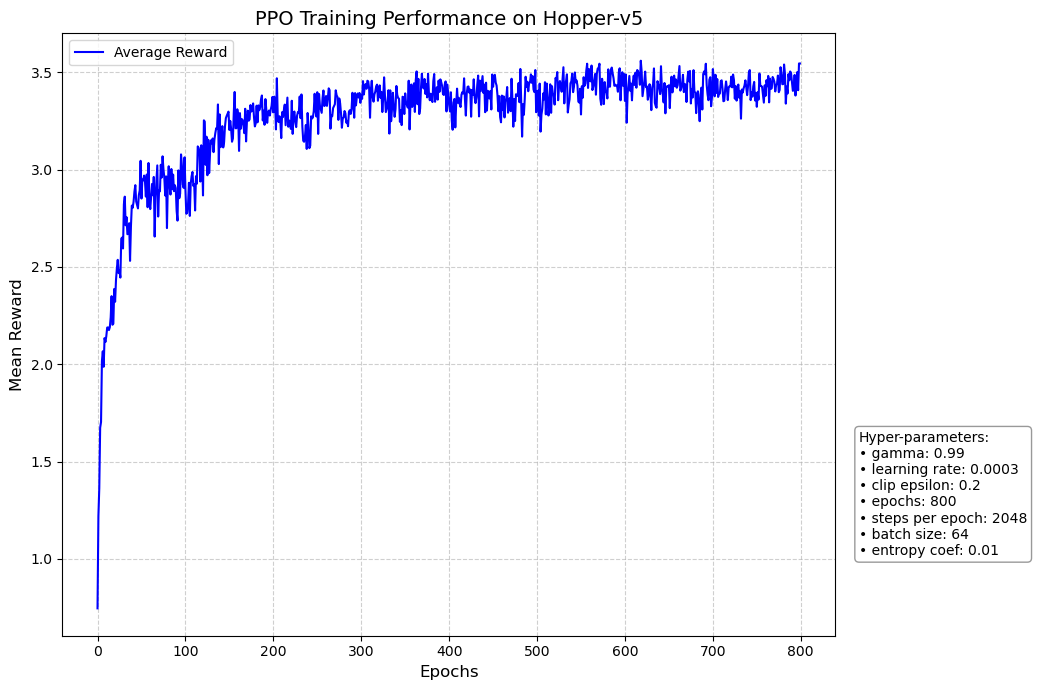

In [24]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # évite au kernel de crash

# ===================================================
# PLOT FINAL
# ===================================================
plt.figure(figsize=(12, 7))
plt.plot(history_rewards, color='blue', label="Average Reward")
plt.title(f"PPO Training Performance on {env_name}", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Mean Reward", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Texte des hyperparamètres (SANS dictionnaire)
hparams_text = (
    "Hyper-parameters:\n"
    f"• gamma: {gamma}\n"
    f"• learning rate: {lr}\n"
    f"• clip epsilon: {clip_eps}\n"
    f"• epochs: {epochs}\n"
    f"• steps per epoch: {steps_per_epoch}\n"
    f"• batch size: {batch_size}\n"
    f"• entropy coef: {entropy_coef}"
)

plt.gcf().text(
    0.72, 0.20,
    hparams_text,
    fontsize=10,
    bbox=dict(
        boxstyle='round',
        facecolor='white',
        edgecolor='gray',
        alpha=0.8
    )
)

plt.tight_layout()
plt.subplots_adjust(right=0.7)
plt.show()


In [25]:
# --- Ligne finale ---
print("-" * 30)
print(f"✅ Entraînement terminé !")
print(f"🏆 Meilleure récompense moyenne enregistrée : {max(history_rewards):.2f}")
print("-" * 30)

------------------------------
✅ Entraînement terminé !
🏆 Meilleure récompense moyenne enregistrée : 3.56
------------------------------


In [33]:
import gymnasium as gym
import torch
from torch.distributions import Normal

device = "cuda" if torch.cuda.is_available() else "cpu"

env = gym.make("Hopper-v5", render_mode="human")
env = gym.wrappers.NormalizeObservation(env)

obs, _ = env.reset()
done = False
total_reward = 0

policy.eval()

while not done:
    obs_t = torch.tensor(obs, dtype=torch.float32).to(device)

    with torch.no_grad():
        mu, std = policy(obs_t)
        act = torch.tanh(mu)   # ACTION DÉTERMINISTE

    obs, reward, terminated, truncated, _ = env.step(act.cpu().numpy())
    done = terminated or truncated
    total_reward += reward

env.close()
print(f"Total reward: {total_reward:.1f}")


Total reward: 73.9


##### Infos au cours de l'entrainement 

L’entraînement des algorithmes **PPO** et **SAC** sur l’environnement **Hopper-v5** met en évidence des contraintes computationnelles importantes ainsi que des problèmes de stabilité de convergence.

##### Ressources de Calcul
L’utilisation du **GPU (CUDA)** est indispensable en raison de la taille des réseaux (couches de 256 neurones).  
L’algorithme **SAC** est particulièrement coûteux, car il met à jour simultanément cinq réseaux avec un *batch size* de 256.

##### Exploration vs Exploitation
Un entraînement trop court empêche la stabilisation de la politique :
- Des gains temporaires apparaissent lors de phases d’exploration réussies.
- Ces gains disparaissent rapidement faute d’une exploitation suffisante.

##### Performances de PPO
Les résultats sont très sensibles aux hyperparamètres et à la durée d’entraînement :
- **800 époques (~70 min)** : récompense limitée à ~3.
- **1000 époques (~79 min)** : amélioration jusqu’à **4.02** grâce à la normalisation des observations.

##### Oubli Catastrophique
Malgré un pic de performance durant l’entraînement, l’agent obtient un score quasi nul lors du test final.  


##### Changement d'environnement
L’environnement **Swimmer-v5**, sans risque de chute, permettrait d’analyser la coordination motrice indépendamment de l’équilibre et d’évaluer plus précisément l’efficacité intrinsèque de **SAC**.
